In [1]:
import os
import pandas as pd

import sklearn.ensemble as ske
import matplotlib.pylab as plt
%matplotlib inline

from bounos.Analyses.Weight import summed_outliers_per_weight

def categorise_dataframe(df):
    # Categories work better as indexes
    for obj_key in df.keys()[df.dtypes == object]:
        try:
            df[obj_key] = df[obj_key].astype('category')
        except TypeError:
            print("Couldn't categorise {}".format(obj_key))
            pass
    return df

def non_zero_rows(df):
    return df[~(df==0).all(axis=1)]

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The questions we want to answer are:
1. What metrics differentiate between what behaviours
2. Do these metrics cross over domains (i.e. comms impacting behaviour etc)

To answer these questions we first have to manipulate the raw dataframe to be weight-indexed with behaviour(`var`) keys on the perspective from the observer to the (potential) attacker in a particular run (summed across the timespace)

While this analysis simply sums both the upper and lower outliers, **this needs extended/readdressed**

# IMPORTANT 
The July 3rd Simulation Run had a small mistake where the Ran

In [2]:
observer = 'Bravo'
target = 'Alfa'
n_nodes = 6
n_metrics = 9

results_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2015-07-03-16-45-26"
results_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2015-07-20-17-47-53"
#shared_h5_path = '/dev/shm/shared.h5'
#Something smells
shared_h5_path = '/home/bolster/src/aietes/results/shared.bkup.h5'
fig_basedir = "/home/bolster/src/thesis/papers/active/16_AAMAS"


with pd.get_store(shared_h5_path) as store:
    joined_target_weights = store.get('joined_target_weights')
    joined_feats = store.get('joined_feats')
    comms_only_feats = store.get('comms_only_feats')
    phys_only_feats = store.get('phys_only_feats')
    comms_only_weights = store.get('comms_only_weights')
    phys_only_weights = store.get('phys_only_weights')

joined_feat_weights = categorise_dataframe(non_zero_rows(joined_feats).T)
comms_feat_weights = categorise_dataframe(non_zero_rows(comms_only_feats).T)
phys_feat_weights = categorise_dataframe(non_zero_rows(phys_only_feats).T)

In [40]:
with pd.get_store(results_path + "/outliers.bkup.h5") as store:
    weight_df = store.get(store.keys()[0])
#weight_df
f=np.random.randn(6)
f

array([-1.112, -0.993, -0.666, -1.152,  2.192,  0.493])

In [70]:
import itertools
tolerance = 1
def npuniq(a):
    return np.unique(a.view(np.dtype((np.void, a.dtype.itemsize*a.shape[1])))).view(a.dtype).reshape(-1, a.shape[1])
combinations = np.asarray([f*i for i in itertools.product([1,-1],repeat=len(f))])

for i in f[np.abs(f)<tolerance]:
    combinations[:,np.where(f==i)]=i
combinations = npuniq(combinations)
len(combinations)

64
[-0.993 -0.666  0.493]


8

In [125]:
from bounos.Analyses.Weight import target_weight_feature_extractor
import itertools
#from bounos.Analyses.Weight import generate_weighted_trust_perspectives
from bounos.Analyses import Trust
with pd.get_store(results_path + '.h5') as store:
    trust_observations = store.trust.xs('Bravo',level='observer', drop_level=False).dropna()
    # Testing if using the full set initially improves things...
    #trust_observations = store.trust.dropna()


def generate_weighted_trust_perspectives(trust_observations, feat_weights, par=True):  
    weighted_trust_perspectives = []
    for w in feat_weights:
        weighted_trust_perspectives.append(Trust.generate_node_trust_perspective(
            trust_observations,
            metric_weights=pd.Series(w),
            par=par
        ))

    return weighted_trust_perspectives
    
def drop_metrics_from_weights_by_key(target_weights, drop_keys):
    reset_by_keys = target_weights.reset_index(level=drop_keys)
    zero_indexes = (reset_by_keys[drop_keys] == 0.0).all(axis=1)
    dropped_target_weights = reset_by_keys[zero_indexes].drop(drop_keys, 1)
    return dropped_target_weights

def plot_result(result, title=None, stds=True, spans=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if spans is not None:
        pd.stats.moments.ewma(result, span=spans).plot(ax=ax)
    else:
        result.plot(ax=ax, alpha=0.3)

    def pltstd(tup):
        mean, std = tup
        ax.axhline(mean + std, alpha=0.3, ls=':', color='green')
        ax.axhline(mean - std, alpha=0.3, ls=':', color='red')

    for i,v in enumerate(result.mean()):
        if i:
            ax.axhline(v, alpha=0.2, ls='--', color='blue')
        else:
            ax.axhline(v, alpha=0.3, ls='-', color='blue')
    if stds:
        map(pltstd, zip(result.mean(), result.std()))
    ax.set_title(title+": mean $\Delta T={:6.4f}$".format(
            assess(result)
        ))
    print(result.describe())
    plt.show()
    return fig,ax,result

  

In [6]:
  
weight_df = joined_target_weights
comms_weights = drop_metrics_from_weights_by_key(weight_df, ['INDD', 'INHD', 'Speed'] )
feats = target_weight_feature_extractor(comms_weights, raw=True)


CombinedTrust
---CombinedBadMouthingPowerControl
---CombinedSelfishTargetSelection
---Shadow
---SlowCoach
Shadow
CombinedBadMouthingPowerControl
SlowCoach
CombinedSelfishTargetSelection


In [7]:
phys_keys = ['INDD', 'INHD', 'Speed']
comm_keys = ['ADelay', 'ARXP', 'ATXP', 'RXThroughput', 'TXThroughput', 'PLR']
target_str = 'CombinedSelfishTargetSelection'
for target, reg in feats['CombinedTrust']:
    if target == target_str:
        f = reg.feature_importances_
        print np.sum(f)
        
_inner = lambda x: map(np.nanmean,np.split(x, [1], axis=1))
assess = lambda x: -np.subtract(*_inner(x))
assess_run = lambda x: assess(x.xs(0,level='run').values)

combinations = [f * i for i in itertools.product([-1,1],repeat=6)]
half= len(combinations)/2
combinations = combinations[:half]
#pd.Series(combinations[0])
basic_weight = Trust.generate_node_trust_perspective(
    trust_observations[comm_keys].xs(target_str, level='var'), 
    metric_weights=pd.Series(f))
basic_score = assess_run(basic_weight)
if np.abs(basic_score)<0.5:
    print("Crappy run {}".format(basic_score))
    perspectives = generate_weighted_trust_perspectives(trust_observations[comm_keys].xs(target_str, level='var'),
                                                    combinations, par=True)


1.0
Crappy run -0.0328811364194


In [17]:
def best_group_in_perspective(perspective):
    test_group = perspective.groupby(level=['observer','run']).apply(assess)
    best_group = test_group.argmax()
    return best_group,test_group[best_group]

group_keys, assessments = zip(*map(best_group_in_perspective,perspectives))
best_weight = combinations[np.argmax(assessments)]
best_run = group_keys[np.argmax(assessments)]
combinations

[array([-0.175, -0.08 , -0.029, -0.337, -0.029, -0.35 ]),
 array([-0.175, -0.08 , -0.029, -0.337, -0.029,  0.35 ]),
 array([-0.175, -0.08 , -0.029, -0.337,  0.029, -0.35 ]),
 array([-0.175, -0.08 , -0.029, -0.337,  0.029,  0.35 ]),
 array([-0.175, -0.08 , -0.029,  0.337, -0.029, -0.35 ]),
 array([-0.175, -0.08 , -0.029,  0.337, -0.029,  0.35 ]),
 array([-0.175, -0.08 , -0.029,  0.337,  0.029, -0.35 ]),
 array([-0.175, -0.08 , -0.029,  0.337,  0.029,  0.35 ]),
 array([-0.175, -0.08 ,  0.029, -0.337, -0.029, -0.35 ]),
 array([-0.175, -0.08 ,  0.029, -0.337, -0.029,  0.35 ]),
 array([-0.175, -0.08 ,  0.029, -0.337,  0.029, -0.35 ]),
 array([-0.175, -0.08 ,  0.029, -0.337,  0.029,  0.35 ]),
 array([-0.175, -0.08 ,  0.029,  0.337, -0.029, -0.35 ]),
 array([-0.175, -0.08 ,  0.029,  0.337, -0.029,  0.35 ]),
 array([-0.175, -0.08 ,  0.029,  0.337,  0.029, -0.35 ]),
 array([-0.175, -0.08 ,  0.029,  0.337,  0.029,  0.35 ]),
 array([-0.175,  0.08 , -0.029, -0.337, -0.029, -0.35 ]),
 array([-0.175

In [14]:
with pd.get_store(results_path + '.h5') as store:
    test_trust_observations = store.trust.dropna()
test_weight = Trust.generate_node_trust_perspective(
    test_trust_observations[comm_keys].xs(target_str, level='var'), 
    metric_weights=pd.Series(best_weight))
#plot_result(pd.stats.moments.ewma(test_weight, span=6), stds=False)

In [ ]:
group_keys, assessments = zip(*map(best_group_in_perspective,perspectives))
from joblib import Parallel, delayed
result = Parallel(n_jobs=-1)(delayed(best_group_in_perspective)(perspective) for perspective in perspectives)


In [15]:
test_group = test_weight.groupby(level=['observer','run']).apply(assess)
best_group = test_group.argmax()
test_group[best_group]

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.13773202950449193

            Alfa      Bravo    Charlie      Delta       Echo
count  55.000000  58.000000  59.000000  59.000000  59.000000
mean    0.401657   0.552683   0.551746   0.553016   0.500336
std     0.281469   0.281146   0.270171   0.262264   0.278918
min     0.057788   0.078235   0.057183   0.051859   0.058512
25%     0.152114   0.320271   0.318588   0.321581   0.284181
50%     0.294133   0.589437   0.630171   0.636727   0.495987
75%     0.659925   0.812111   0.734571   0.752861   0.736879
max     0.948141   0.948141   0.948141   0.895705   0.948141


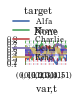

In [16]:
plot_result(test_weight\
            .xs(best_group, level=['observer','run'])\
            .dropna(axis=1, how='all'), stds=True, spans=6)

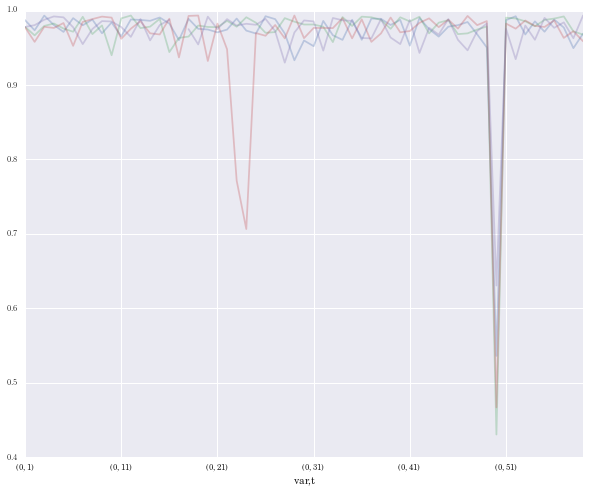

In [82]:
res = test_weight\
            .xs(best_group, level=['observer','run'])\
            .dropna(axis=1, how='all')
res.iloc[:,1:].plot(alpha=0.3, figsize=(10,8), legend=False)

In [30]:
from aietes.Tools import mkcpickle, uncpickle, var_rename_dict, map_levels
with pd.get_store(results_path + '.h5') as store:
    test_trust_observations = store.trust.dropna()
    
map_levels(test_trust_observations, var_rename_dict)
moar = uncpickle(fig_basedir+'/best_comms_runs')
d=moar['Fair']
d

{u'MPC': (('Bravo', 2),
  array([ 0.046,  0.069,  0.664,  0.029, -0.042, -0.15 ])),
 u'STS': (('Bravo', 2),
  array([ 0.097,  0.082,  0.048,  0.116, -0.609, -0.048])),
 u'Shadow': (('Charlie', 2),
  array([-0.339,  0.3  ,  0.026,  0.116,  0.196, -0.024])),
 u'SlowCoach': (('Charlie', 2),
  array([-0.082,  0.308,  0.02 ,  0.088,  0.483, -0.019]))}

In [98]:
for key, (group, weight) in moar['Fair'].items():
    print(key)
    test_weight = Trust.generate_node_trust_perspective(
        test_trust_observations[comm_keys].xs(key, level='var'), 
        metric_weights=pd.Series(weight))
    res = test_weight\
                .dropna(axis=1, how='all')

Shadow
MPC
SlowCoach
STS


            Alfa      Bravo    Charlie      Delta    Foxtrot
count  59.000000  59.000000  58.000000  59.000000  59.000000
mean    0.112645   0.600386   0.554268   0.642816   0.649448
std     0.213061   0.396649   0.384462   0.368143   0.366140
min     0.000337   0.007682   0.012544   0.000250   0.004639
25%     0.005239   0.113202   0.163171   0.304415   0.320478
50%     0.016013   0.814010   0.612502   0.852245   0.844100
75%     0.093248   0.964101   0.940232   0.960910   0.941132
max     0.993670   0.999456   0.999178   0.998775   0.999485


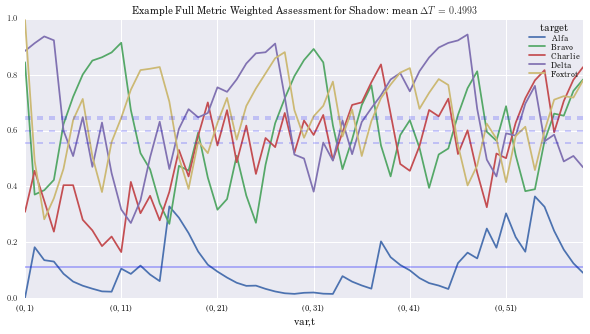

            Alfa      Bravo    Charlie      Delta    Foxtrot
count  59.000000  59.000000  59.000000  59.000000  59.000000
mean    0.043509   0.946904   0.947307   0.950100   0.950353
std     0.032876   0.040944   0.047700   0.039263   0.042594
min     0.002756   0.840694   0.730468   0.803500   0.793200
25%     0.021364   0.919604   0.937455   0.930403   0.940243
50%     0.036312   0.960857   0.964676   0.963130   0.963071
75%     0.062314   0.974192   0.977173   0.978645   0.980051
max     0.135622   0.997060   0.997287   0.997102   0.996421


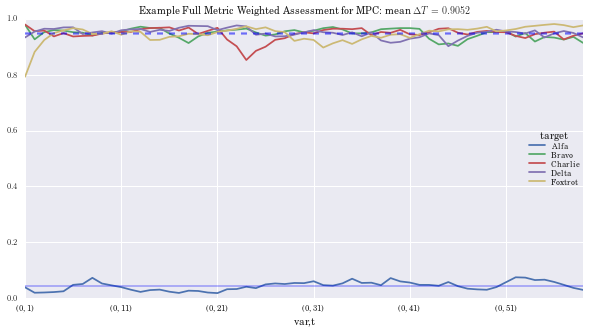

            Alfa    Charlie      Delta       Echo    Foxtrot
count  58.000000  59.000000  59.000000  59.000000  59.000000
mean    0.074823   0.746520   0.682199   0.673653   0.707738
std     0.101940   0.230439   0.292706   0.253984   0.253278
min     0.004748   0.077500   0.039519   0.147618   0.031240
25%     0.026510   0.609188   0.547807   0.457789   0.572684
50%     0.038801   0.819537   0.794308   0.755854   0.795812
75%     0.055923   0.911278   0.909081   0.893049   0.913091
max     0.450319   0.997643   0.986911   0.984445   0.981711


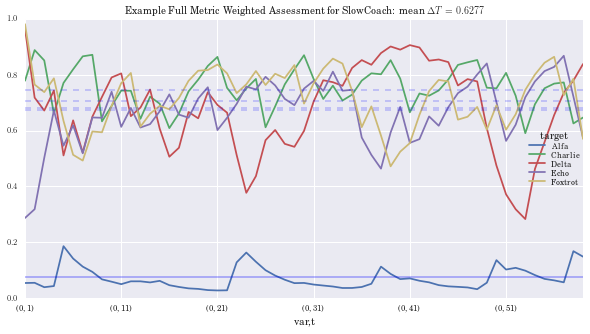

            Alfa      Bravo      Delta       Echo    Foxtrot
count  52.000000  59.000000  59.000000  59.000000  59.000000
mean    0.381309   0.510367   0.521546   0.396147   0.503417
std     0.300284   0.326444   0.304167   0.274494   0.323450
min     0.003969   0.007747   0.023525   0.001386   0.017251
25%     0.132430   0.174267   0.227569   0.155636   0.168235
50%     0.261215   0.576859   0.591707   0.336615   0.503510
75%     0.634445   0.810808   0.769683   0.591583   0.765541
max     0.966354   0.981069   0.979419   0.935624   0.973692


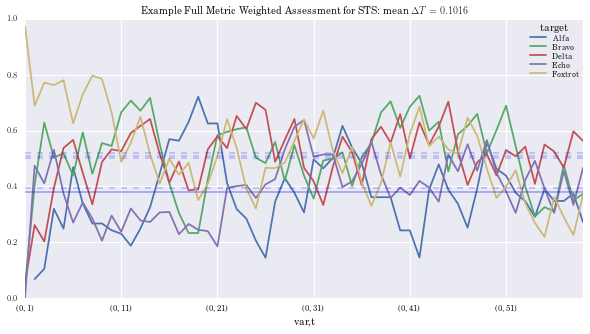

            Alfa      Bravo    Charlie      Delta    Foxtrot
count  59.000000  59.000000  58.000000  59.000000  59.000000
mean    0.136561   0.622326   0.528166   0.483444   0.597848
std     0.239245   0.369726   0.369238   0.374533   0.372295
min     0.000000   0.000078   0.000004   0.000000   0.002721
25%     0.000934   0.215685   0.190979   0.072138   0.184869
50%     0.022330   0.754086   0.482443   0.524215   0.676095
75%     0.162682   0.976595   0.935095   0.784554   0.975873
max     0.999157   1.000000   1.000000   0.999989   1.000000


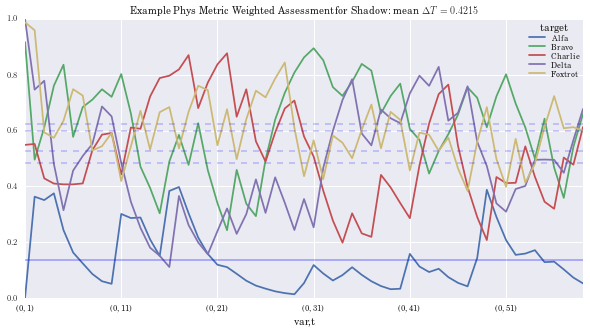

            Alfa      Bravo    Charlie      Delta    Foxtrot
count  59.000000  59.000000  59.000000  59.000000  59.000000
mean    0.468685   0.459262   0.454574   0.518243   0.534357
std     0.379323   0.374489   0.364972   0.354526   0.385221
min     0.000000   0.000000   0.000000   0.000187   0.000000
25%     0.119582   0.058284   0.097635   0.217763   0.129900
50%     0.402207   0.452495   0.350002   0.515606   0.526448
75%     0.866548   0.860450   0.785848   0.889870   0.925827
max     1.000000   0.999954   1.000000   1.000000   0.999803


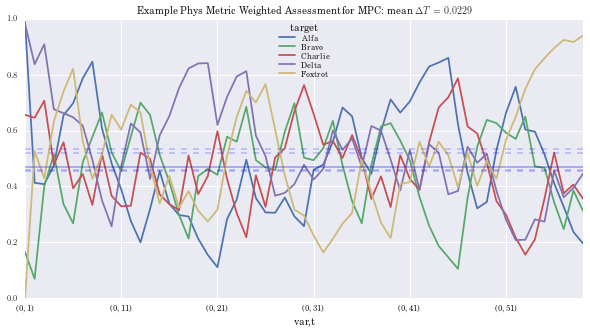

            Alfa      Bravo    Charlie      Delta    Foxtrot
count  59.000000  59.000000  59.000000  59.000000  59.000000
mean    0.001134   0.702110   0.857552   0.760337   0.708960
std     0.003380   0.380429   0.202105   0.315657   0.310883
min     0.000000   0.000185   0.155560   0.010273   0.000000
25%     0.000000   0.331972   0.811777   0.702114   0.492969
50%     0.000000   0.945204   0.946087   0.921027   0.849199
75%     0.000066   0.983398   0.992673   0.974974   0.971117
max     0.017192   1.000000   1.000000   1.000000   0.999839


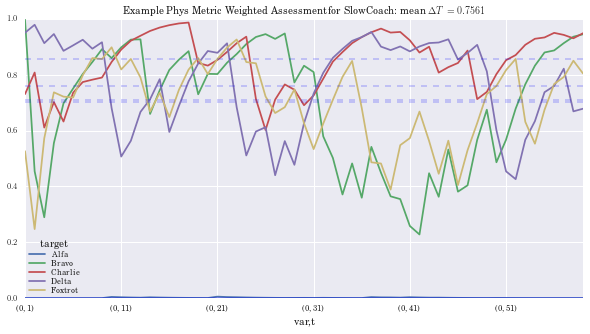

            Alfa    Charlie      Delta       Echo    Foxtrot
count  46.000000  59.000000  59.000000  59.000000  59.000000
mean    0.409935   0.415298   0.470269   0.445783   0.390486
std     0.383963   0.400392   0.447564   0.412013   0.342072
min     0.000000   0.000008   0.000000   0.000227   0.000000
25%     0.096975   0.037830   0.036738   0.046403   0.096866
50%     0.208595   0.197118   0.216441   0.277361   0.257528
75%     0.846754   0.853499   0.969226   0.940701   0.701746
max     0.999703   1.000000   1.000000   1.000000   1.000000


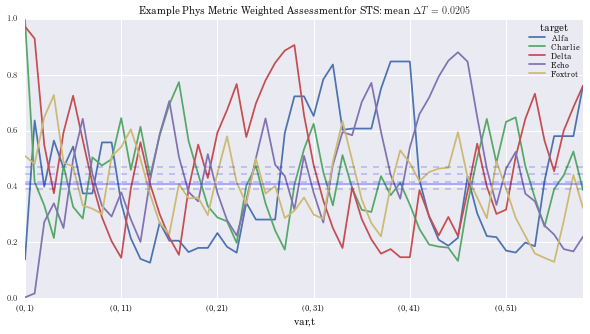

            Alfa      Bravo      Delta       Echo    Foxtrot
count  59.000000  59.000000  58.000000  59.000000  59.000000
mean    0.238001   0.438827   0.549785   0.530078   0.583227
std     0.229365   0.282175   0.323282   0.312182   0.327575
min     0.008544   0.033649   0.011330   0.016498   0.011132
25%     0.055952   0.221157   0.244523   0.260695   0.302608
50%     0.130490   0.391822   0.643072   0.545712   0.736130
75%     0.427891   0.597675   0.827044   0.815130   0.886654
max     0.825939   0.990073   0.987651   0.988868   0.981135


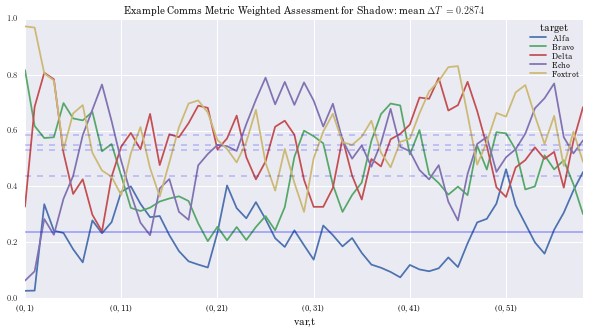

            Alfa    Charlie      Delta       Echo    Foxtrot
count  59.000000  59.000000  59.000000  59.000000  59.000000
mean    0.022262   0.977275   0.975959   0.977400   0.975677
std     0.012242   0.013067   0.013615   0.011522   0.012281
min     0.006922   0.925247   0.931059   0.928595   0.938175
25%     0.015300   0.970630   0.968716   0.971340   0.969114
50%     0.018583   0.979506   0.977306   0.978831   0.979333
75%     0.028544   0.986445   0.987942   0.985738   0.984996
max     0.053693   0.993484   0.993344   0.993484   0.993351


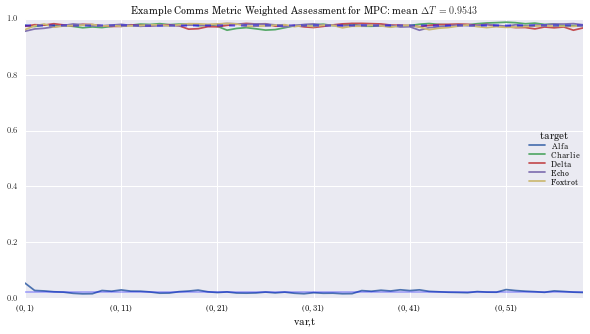

            Alfa      Bravo      Delta       Echo    Foxtrot
count  58.000000  59.000000  59.000000  59.000000  59.000000
mean    0.303783   0.607059   0.545409   0.612616   0.523914
std     0.283416   0.319243   0.343420   0.358347   0.308205
min     0.000417   0.021954   0.004106   0.001638   0.014456
25%     0.032492   0.348248   0.201231   0.240711   0.285679
50%     0.210862   0.725892   0.555677   0.800856   0.495427
75%     0.566100   0.908872   0.874978   0.927536   0.797240
max     0.955028   0.996312   0.993959   0.987800   0.991470


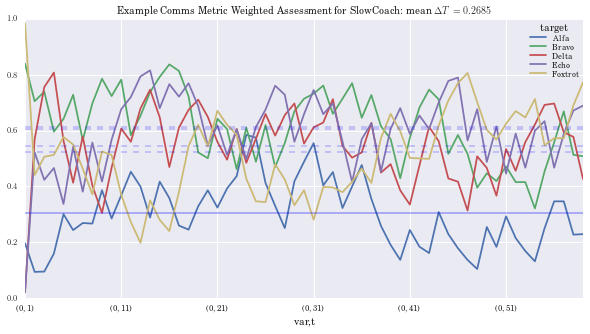

            Alfa    Charlie      Delta       Echo    Foxtrot
count  51.000000  58.000000  59.000000  59.000000  59.000000
mean    0.374024   0.565285   0.498733   0.558761   0.538504
std     0.404915   0.378784   0.391732   0.411084   0.430651
min     0.004171   0.002559   0.005522   0.003331   0.003095
25%     0.032066   0.140843   0.072026   0.087136   0.040130
50%     0.110701   0.638165   0.441428   0.691666   0.698039
75%     0.761646   0.958648   0.921956   0.965429   0.968809
max     0.996340   0.997457   0.997457   0.997457   0.997438


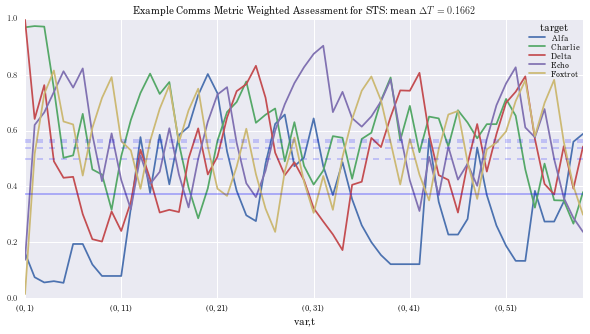

In [166]:
plt.rcParams['figure.figsize'] = 10,5

with pd.get_store(results_path + '.h5') as store:
    trust_observations = store.trust.dropna()
map_levels(trust_observations, var_rename_dict)
key_d = {
    'full': None,
    'comms': comm_keys,
    'phys': phys_keys
}
from collections import defaultdict
plots = {}
weights = {}

inverted_results = defaultdict(list)
for subset_str, key in key_d.items():
    if key is None:
        _trust_observations = trust_observations
    else:
        _trust_observations = trust_observations[key]
    best_d = uncpickle(fig_basedir+'/best_{}_runs'.format(subset_str))['Fair']
    for target_str, best in best_d.items():
        test_weight = Trust.generate_node_trust_perspective(
            _trust_observations.xs(target_str, level='var'),
            metric_weights=pd.Series(best[1]))
        weights[(subset_str,target_str)] = best[1].copy()
        plots[(subset_str,target_str)]=plot_result(test_weight\
                    .xs(best[0], level=['observer','run'])\
                    .dropna(axis=1, how='all'), stds=False, spans=6, 
                    title="Example {} Metric Weighted Assessment for {}".format(
                subset_str.capitalize(),
                target_str
            ))
for (subset_str, target_str), (fig,ax,result) in plots.items():
    inverted_results[subset_str].append((target_str,result))


In [167]:
ass = {}
for k,v in inverted_results.items():
    for kk, vv in v:
        ass[(k,kk)]=assess(vv)

In [220]:
df = pd.DataFrame.from_dict(ass, orient='index')
df.index = pd.MultiIndex.from_tuples(df.index)
df.index.names = ['Domain','Behaviour']
df.columns = ['$\DeltaT$']
df.sort_index(inplace=True)
df =df.unstack('Behaviour')
df.sort_index(inplace=True, axis=0)
df['Avg.']=df.mean(axis=1)
df=df.T
df['Avg.']=df.mean(axis=1)
df=df.T
print df.to_latex(escape=False)

\begin{tabular}{lrrrrr}
\toprule
{} & $\DeltaT$ &           &           &           &      Avg. \\
Behaviour &       MPC &       STS &    Shadow & SlowCoach &           \\
\midrule
Domain &           &           &           &           &           \\
comms  &  0.954316 &  0.166191 &  0.287375 &  0.268467 &  0.419087 \\
full   &  0.905157 &  0.101561 &  0.499329 &  0.627704 &  0.533438 \\
phys   &  0.022924 &  0.020524 &  0.421512 &  0.756106 &  0.305266 \\
Avg.   &  0.627466 &  0.096092 &  0.402738 &  0.550759 &  0.419264 \\
\bottomrule
\end{tabular}



In [ ]:
# Single DataFrame of all features against known good
var_weights = target_weights.apply(lambda s: s/target_weights.CombinedTrust, axis=0).dropna()
known_good_features = \
    pd.concat([feature_extractor(s.reset_index(),var) for var,s  in var_weights.iteritems()],
              keys=var_weights.keys(), names=['var','metric'])

These results handily confirm that there is a 'signature' of badmouthing as RandomFlatWalk was incorrectly configured. 

Need to: 
1. Perform multi-run tolerance analysis of metrics (i.e. turn the below into a boxplot)
2. Perform cross correlation analysis on metrics across runs/behaviours (what metrics are redundant)

In [ ]:
_=known_good_features.unstack().plot(kind='bar')

In [ ]:
_=known_good_features.unstack().boxplot()

In [ ]:
import operator

def target_weight_feature_extractor(target_weights):
    known_good_features_d = {}
    for basekey in target_weights.keys(): # Parallelisable
        print basekey
        # Single DataFrame of all features against one behaviour
        var_weights = target_weights.apply(lambda s: s/target_weights[basekey], axis=0).dropna()
        known_good_features_d[basekey] = \
            pd.concat([feature_extractor(s.reset_index(),var) for var,s  in var_weights.iteritems()],
                      keys=var_weights.keys(), names=['var','metric'])
            
    return known_good_features_d


def dataframe_weight_filter(df, keys):
    indexes = [(df.index.get_level_values(k)==0.0) for k in keys]
    return df.loc[reduce(operator.and_,indexes)]

phys_keys = ['INDD','INHD','Speed']
comm_keys = ['ADelay','ARXP','ATXP','RXThroughput','TXThroughput','PLR']

In [ ]:
#Comms Only Weights
comms_target_weights=dataframe_weight_filter(target_weights,phys_keys)
comms_target_weights.reset_index(level=phys_keys, drop=True, inplace=True)
comms_features_d = target_weight_feature_extractor(comms_target_weights)
for var,feat in comms_features_d.iteritems():
    feat.unstack().plot(kind='bar', title=var)

In [ ]:
#Phys Only Weights
phys_target_weights=dataframe_weight_filter(target_weights,comm_keys)
phys_target_weights.reset_index(level=comm_keys, drop=True, inplace=True)
phys_features_d = target_weight_feature_extractor(phys_target_weights)
for var,feat in phys_features_d.iteritems():
    feat.unstack().plot(kind='bar', title=var)